In [1]:
import pandas as pd
import os

# Load the provided CSV file to inspect its contents
path = os.path.join('..','results','merged_data.csv')
data = pd.read_csv(path)

# Get an initial idea of the structure of the dataset
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007123 entries, 0 to 1007122
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Time stamp  1007123 non-null  object
 1   Value       1007123 non-null  object
 2   Variable    1007123 non-null  object
dtypes: object(3)
memory usage: 23.1+ MB


,Time stamp,Value,Variable
0,07/07/2023 10:41:03,"491,00",TR2_Pot_att
1,07/07/2023 10:26:03,"498,00",TR2_Pot_att
2,07/07/2023 10:11:03,"498,00",TR2_Pot_att
3,07/07/2023 09:56:03,"538,00",TR2_Pot_att
4,07/07/2023 09:41:03,"505,00",TR2_Pot_att


Preprocessing the data

In [2]:
# Parsing 'Time stamp' into a datetime object
data['Time stamp'] = pd.to_datetime(data['Time stamp'], format='%d/%m/%Y %H:%M:%S')

# Converting 'Value' column to numerical format, replacing dots with nothing, commas with dots
data['Value'] = data['Value'].str.replace('.','',regex=False).str.replace(',', '.').astype(float)

# Display the updated dataframe to confirm changes
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007123 entries, 0 to 1007122
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Time stamp  1007123 non-null  datetime64[ns]
 1   Value       1007123 non-null  float64       
 2   Variable    1007123 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.1+ MB


,Time stamp,Value,Variable
0,2023-07-07 10:41:03,491.0,TR2_Pot_att
1,2023-07-07 10:26:03,498.0,TR2_Pot_att
2,2023-07-07 10:11:03,498.0,TR2_Pot_att
3,2023-07-07 09:56:03,538.0,TR2_Pot_att
4,2023-07-07 09:41:03,505.0,TR2_Pot_att


In [3]:
# Group by Variable and Time stamp (day) and calculate the mean of Value
data_day_mean = data

data_day_mean['Day'] = data_day_mean['Time stamp'].dt.date
data_day_mean = data_day_mean.groupby(['Day', 'Variable']).mean('Value').reset_index()

data_day_mean.head()

,Day,Variable,Value
0,2022-01-06,TR1_Corr_1,626.222222
1,2022-01-06,TR1_Corr_2,650.818182
2,2022-01-06,TR1_Corr_3,602.454545
3,2022-01-06,TR1_Corr_N,28.250000
4,2022-01-06,TR1_Pot_att,437.230769


Group similar variables based on their names and plot them

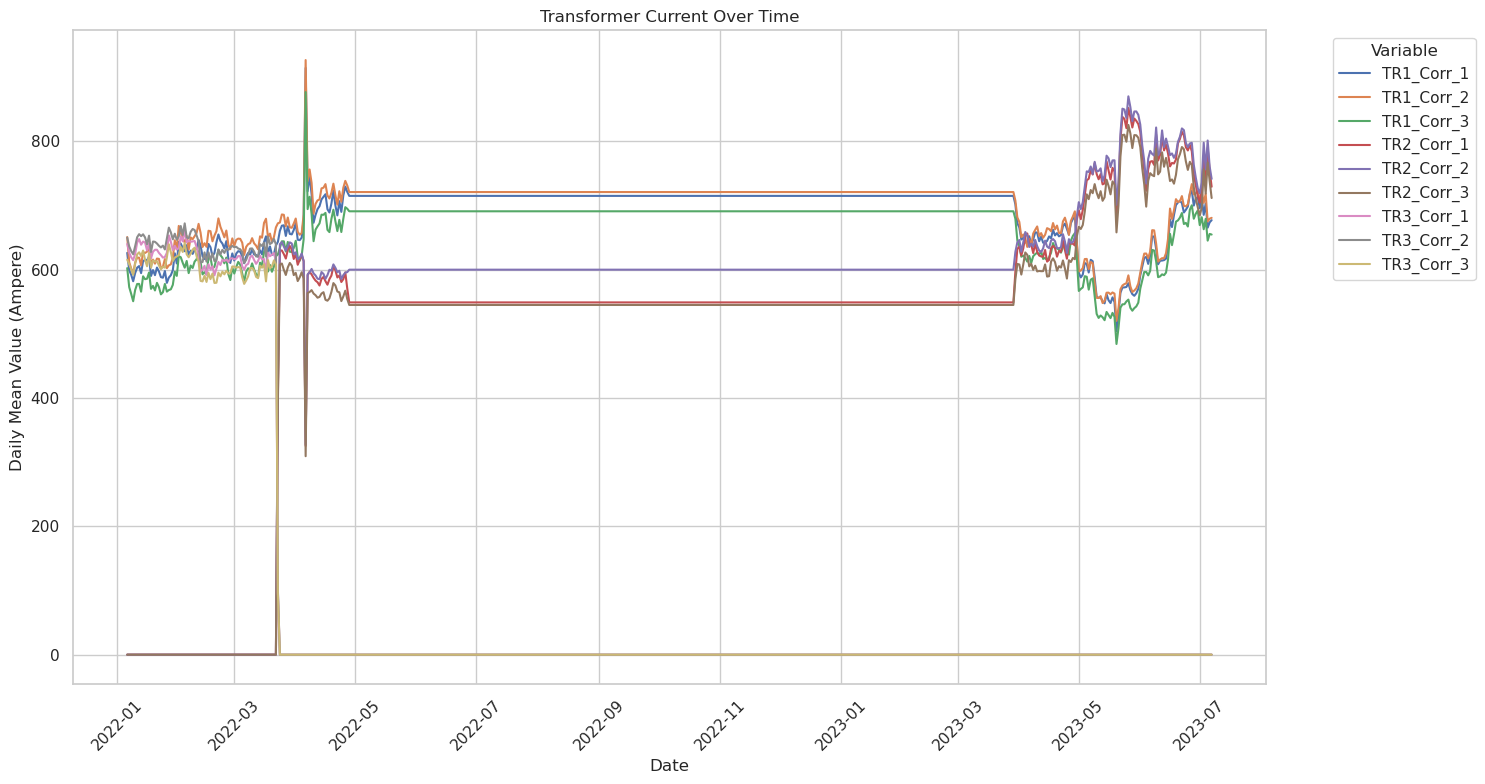

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

variables = data_day_mean['Variable'].unique()

corr123_variables = [var for var in variables if var.startswith('TR') and 'Corr' in var and not var.endswith('N')]
for variable in corr123_variables:
    subset = data_day_mean[data_day_mean['Variable'] == variable]
    plt.plot(subset['Day'], subset['Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Daily Mean Value (Ampere)')
plt.title('Transformer Current Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

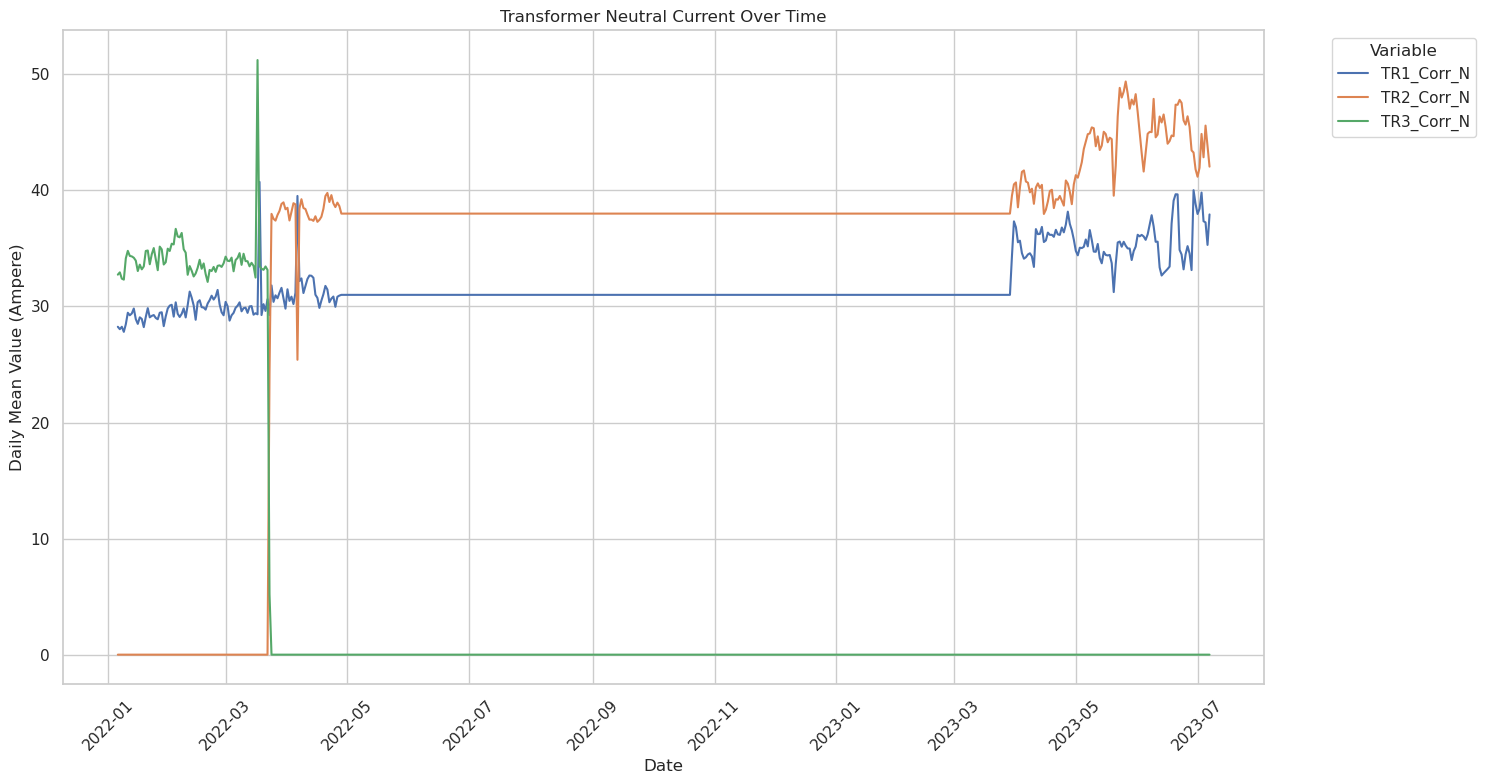

In [5]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

trN_variables = [var for var in variables if var.startswith('TR') and var.endswith('N')]
for variable in trN_variables:
    subset = data_day_mean[data_day_mean['Variable'] == variable]
    plt.plot(subset['Day'], subset['Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Daily Mean Value (Ampere)')
plt.title('Transformer Neutral Current Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

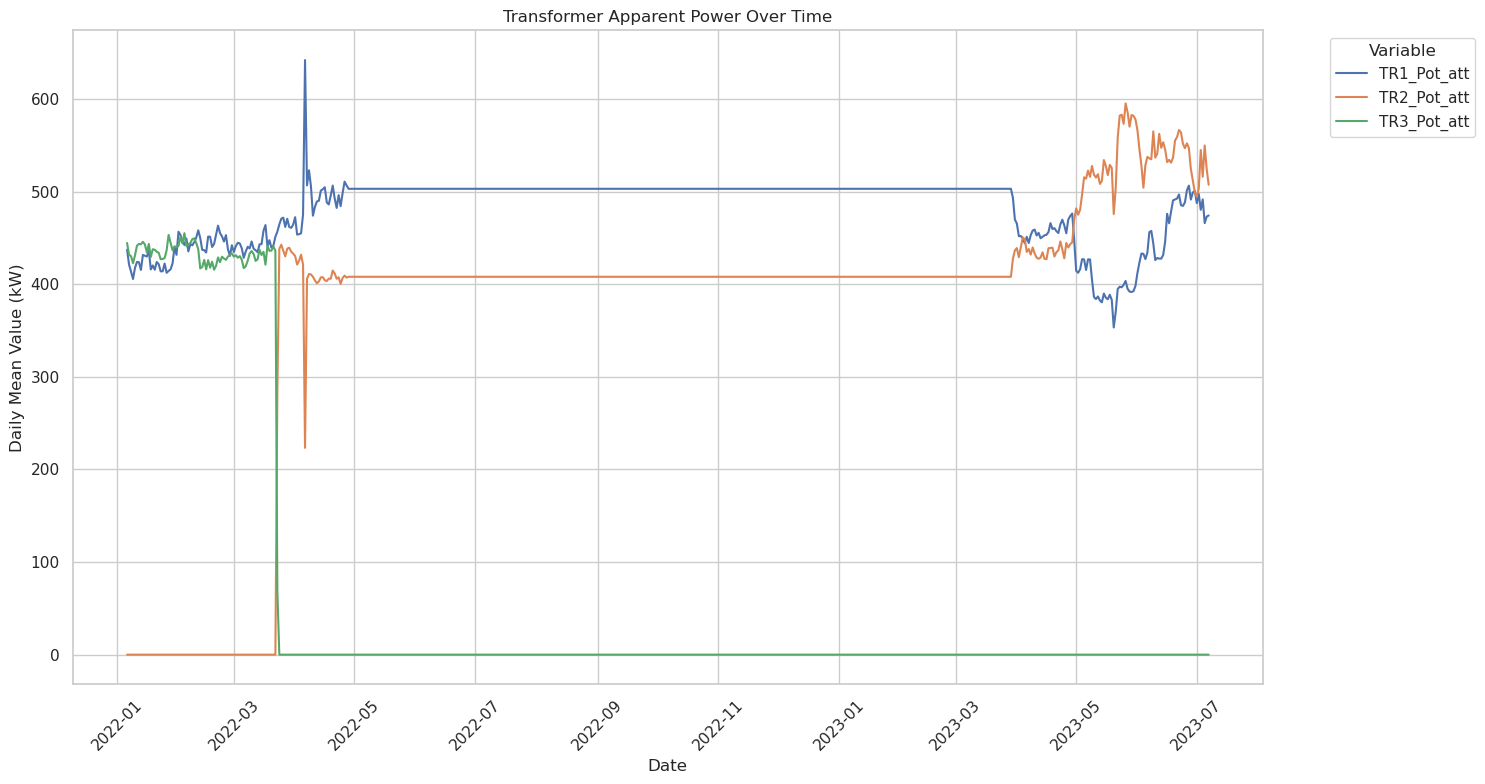

In [6]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

trN_variables = [var for var in variables if 'Pot_att' in var]
for variable in trN_variables:
    subset = data_day_mean[data_day_mean['Variable'] == variable]
    plt.plot(subset['Day'], subset['Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Daily Mean Value (kW)')
plt.title('Transformer Apparent Power Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

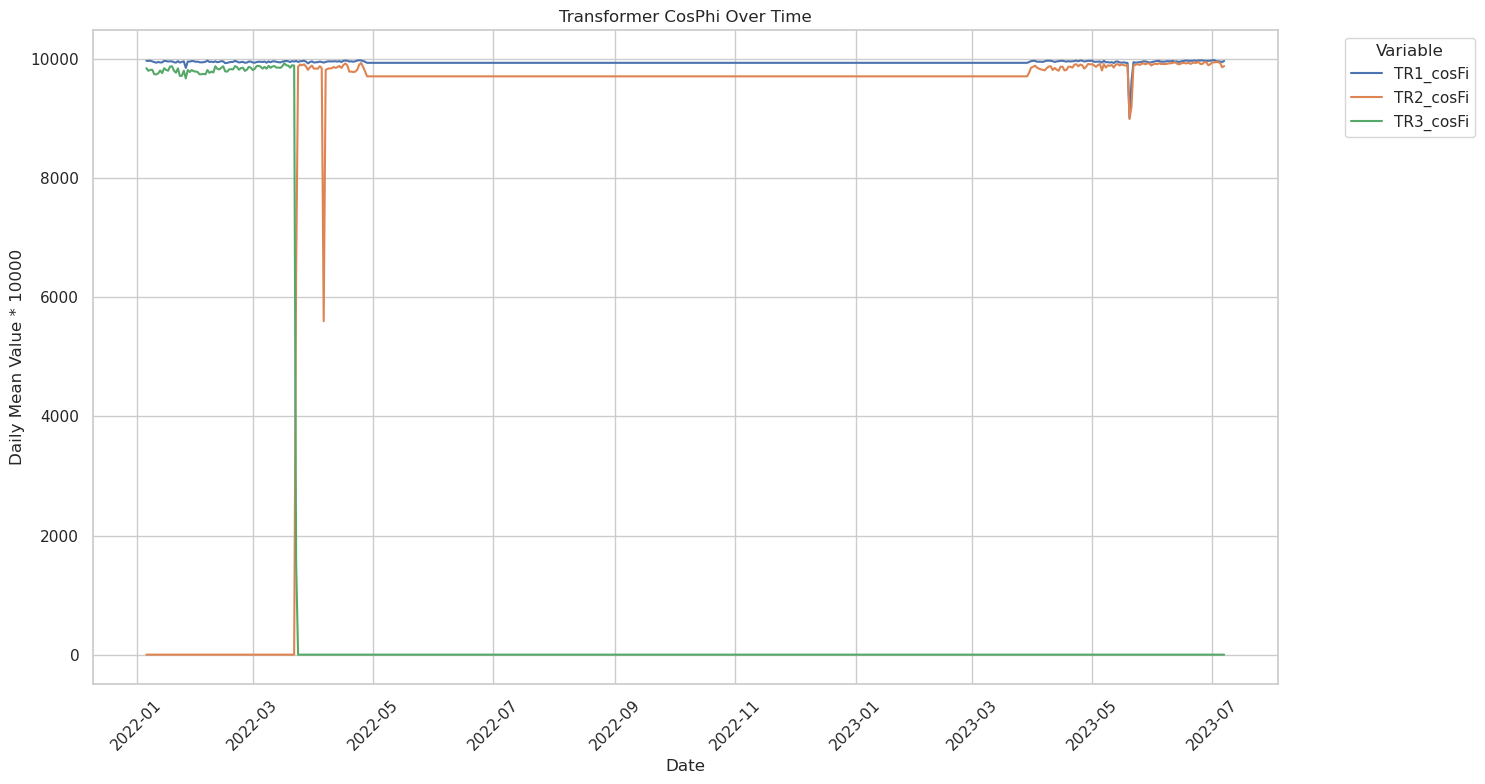

In [7]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

cosfi = [var for var in variables if var.endswith('cosFi')]
for variable in cosfi:
    subset = data_day_mean[data_day_mean['Variable'] == variable]
    plt.plot(subset['Day'], subset['Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Daily Mean Value * 10000')
plt.title('Transformer CosPhi Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

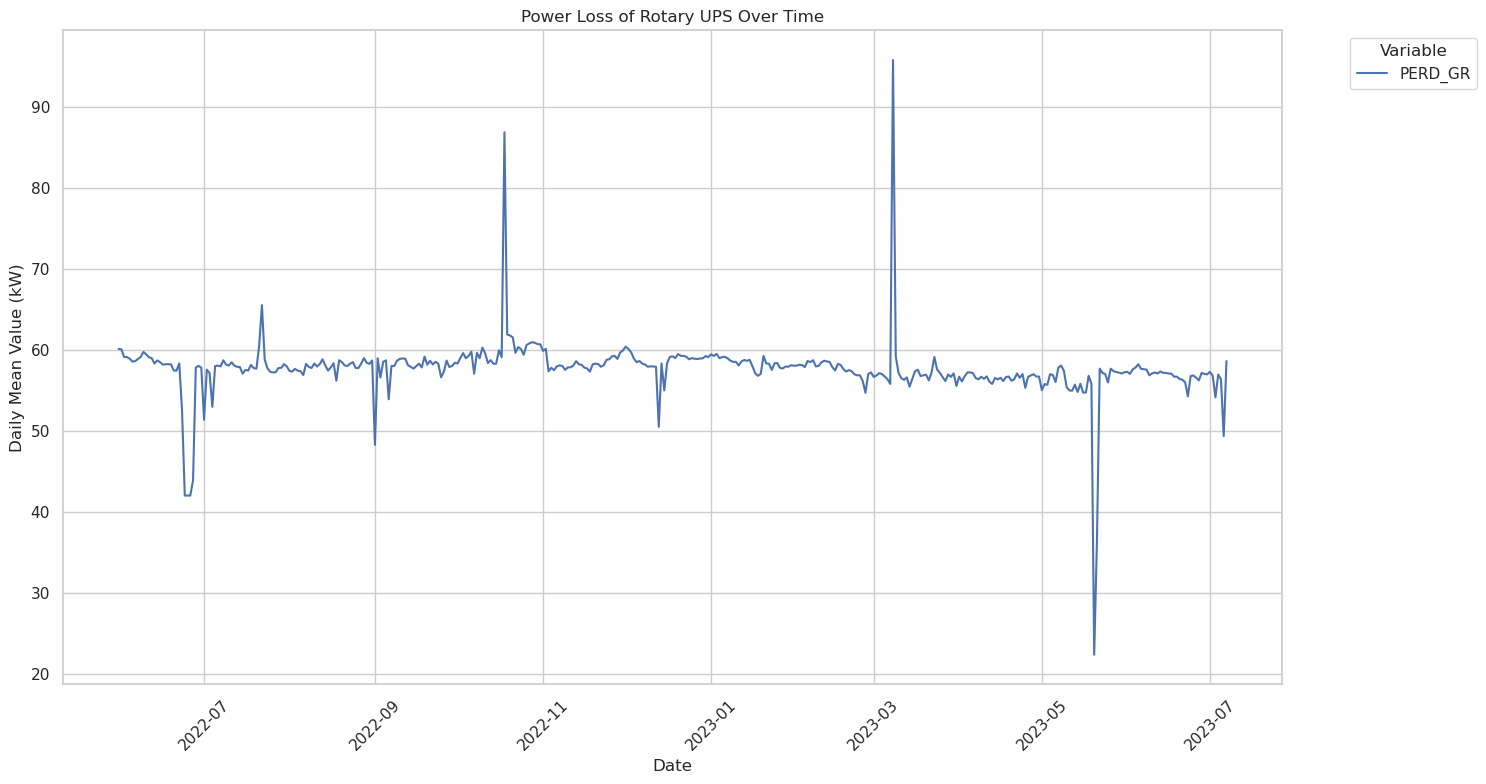

In [8]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

perd_gr = data_day_mean[data_day_mean['Variable'] == 'PERD_GR']
plt.plot(perd_gr['Day'], perd_gr['Value'], label='PERD_GR')

plt.xlabel('Date')
plt.ylabel('Daily Mean Value (kW)')
plt.title('Power Loss of Rotary UPS Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

We can drop the following variable, since it's the sum of other variables in the dataset and there's only data for it for 2 months

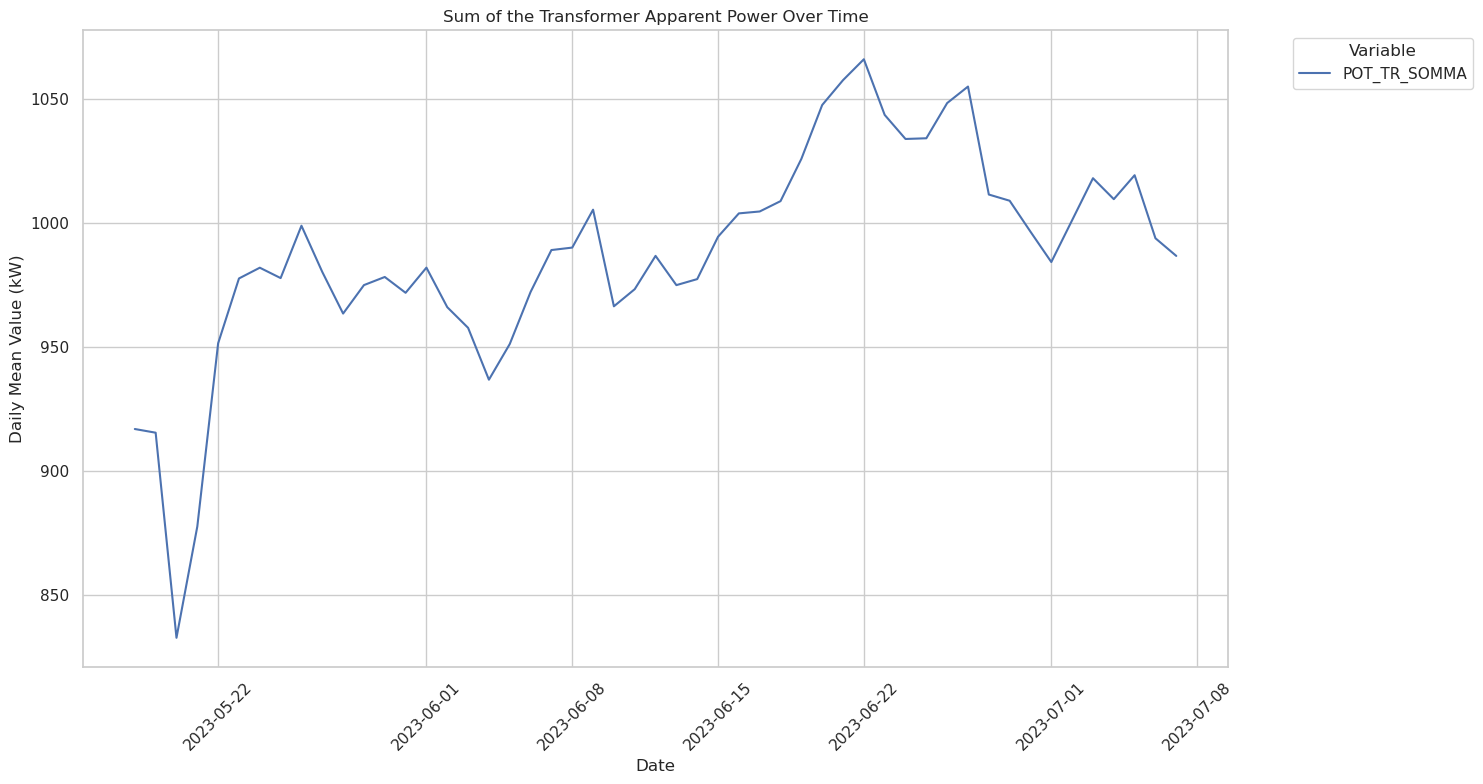

In [9]:
# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

somma = data_day_mean[data_day_mean['Variable'] == 'POT_TR_SOMMA']
plt.plot(somma['Day'], somma['Value'], label='POT_TR_SOMMA')

plt.xlabel('Date')
plt.ylabel('Daily Mean Value (kW)')
plt.title('Sum of the Transformer Apparent Power Over Time')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

Standardize selected variables

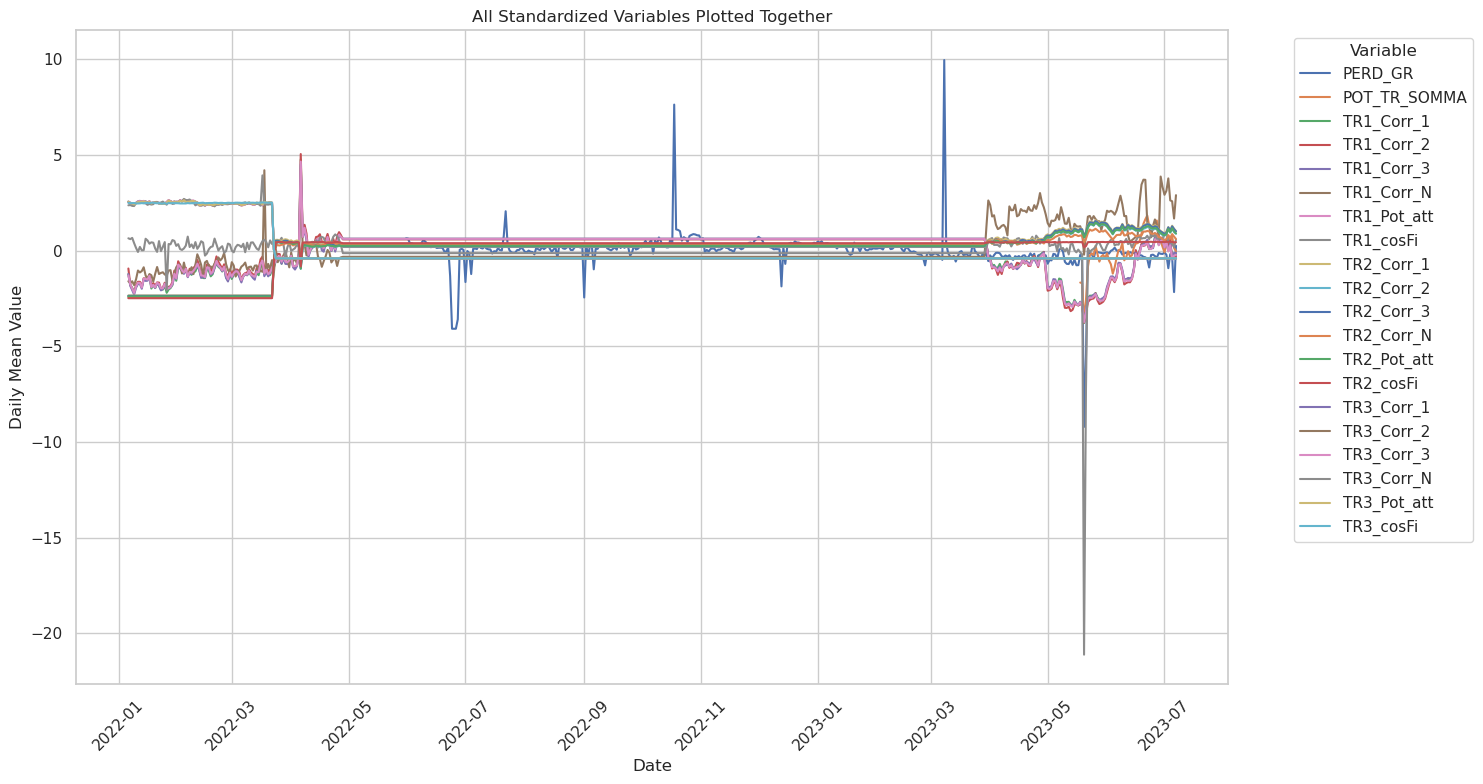

In [10]:
from sklearn.preprocessing import StandardScaler

# Grouping the data by 'Variable'
grouped_data = data_day_mean.groupby('Variable')

# Initializing an empty dataframe to hold the standardized data
standardized_data = pd.DataFrame()

scaler = StandardScaler()

# Standardizing the 'Value' for each group
for name, group in grouped_data:
    group['Standardized Value'] = scaler.fit_transform(group[['Value']])
    standardized_data = pd.concat([standardized_data, group])

standardized_data

# Plotting the mean value for each variable per day
plt.figure(figsize=(15, 8))

variables = standardized_data['Variable'].unique()

for variable in variables:
    subset = standardized_data[standardized_data['Variable'] == variable]
    plt.plot(subset['Day'], subset['Standardized Value'], label=variable)

plt.xlabel('Date')
plt.ylabel('Daily Mean Value')
plt.title('All Standardized Variables Plotted Together')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

Reshape the dataset from long to wide format

In [11]:
wide_standardized = standardized_data.pivot(index='Day', columns='Variable', values='Standardized Value').reset_index()

wide_standardized

Variable,Day,PERD_GR,POT_TR_SOMMA,TR1_Corr_1,TR1_Corr_2,TR1_Corr_3,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_1,...,TR2_Corr_3,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_1,TR3_Corr_2,TR3_Corr_3,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
0,2022-01-06,NaN,NaN,-1.231298,-0.933498,-1.223404,-1.600095,-1.292598,0.646569,-2.341407,...,-2.361081,-2.449617,-2.390089,-2.485613,2.569779,2.545060,2.534740,2.370580,2.563919,2.498133
1,2022-01-07,NaN,NaN,-1.795391,-1.784379,-1.840692,-1.696996,-1.760198,0.603159,-2.341407,...,-2.361081,-2.449617,-2.390089,-2.485613,2.506628,2.483190,2.500779,2.387237,2.478809,2.485275
2,2022-01-08,NaN,NaN,-1.939701,-1.994978,-2.060963,-1.600095,-1.978692,0.666575,-2.341407,...,-2.361081,-2.449617,-2.390089,-2.485613,2.473594,2.449704,2.464601,2.341381,2.468522,2.489890
3,2022-01-09,NaN,NaN,-2.151832,-2.166259,-2.300567,-1.803588,-2.212015,0.394216,-2.341407,...,-2.361081,-2.449617,-2.390089,-2.485613,2.452700,2.427270,2.422261,2.334326,2.417645,2.489911
4,2022-01-10,NaN,NaN,-1.887047,-1.797936,-1.935404,-1.498349,-1.863998,0.144100,-2.341407,...,-2.361081,-2.449617,-2.390089,-2.485613,2.498309,2.484040,2.504258,2.489532,2.474847,2.468301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,2023-07-03,-0.916888,0.708592,0.000462,0.223319,0.038344,3.777928,-0.040692,0.440832,1.226710,...,1.218077,0.814704,1.140090,0.462033,-0.402009,-0.402037,-0.401994,-0.401177,-0.402055,-0.402153
544,2023-07-04,-0.180669,0.510244,0.369686,0.529728,0.379178,2.629648,0.285839,0.448404,1.070755,...,1.039245,0.668427,0.953332,0.461576,-0.402009,-0.402037,-0.401994,-0.401177,-0.402055,-0.402153
545,2023-07-05,-0.330154,0.737084,-0.414483,-0.404863,-0.330946,2.581197,-0.458917,0.357539,1.302405,...,1.268306,0.867000,1.172150,0.457968,-0.402009,-0.402037,-0.401994,-0.401177,-0.402055,-0.402153
546,2023-07-06,-2.165179,0.139724,-0.241571,-0.313347,-0.112630,1.680015,-0.254949,0.182434,1.138039,...,1.131274,0.740429,1.007057,0.436132,-0.402009,-0.402037,-0.401994,-0.401177,-0.402055,-0.402153


Correlation matrix of all variables except the removed one

In [12]:
wide_standardized_nosomma = wide_standardized.drop('POT_TR_SOMMA', axis=1)

wide_standardized_nosomma.corr()

/tmp/ipykernel_26431/1563161639.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  wide_standardized_nosomma.corr()


Variable,PERD_GR,TR1_Corr_1,TR1_Corr_2,TR1_Corr_3,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_1,TR2_Corr_2,TR2_Corr_3,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_1,TR3_Corr_2,TR3_Corr_3,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
Variable,,,,,,,,,,,,,,,,,,,
PERD_GR,1.000000,0.295472,0.287289,0.292566,-0.164748,0.292697,0.476216,-0.201901,-0.189253,-0.196174,-0.162135,-0.187185,0.116755,NaN,NaN,NaN,NaN,NaN,NaN
TR1_Corr_1,0.295472,1.000000,0.993892,0.998436,-0.192159,0.998831,0.057588,0.291037,0.354289,0.313706,0.429433,0.348069,0.528391,-0.549708,-0.549335,-0.549588,-0.546246,-0.549230,-0.548839
TR1_Corr_2,0.287289,0.993892,1.000000,0.993701,-0.231370,0.996613,0.066262,0.217910,0.280365,0.240146,0.356005,0.274068,0.458749,-0.481491,-0.480815,-0.481171,-0.477608,-0.480737,-0.480185
TR1_Corr_3,0.292566,0.998436,0.993701,1.000000,-0.200648,0.998879,0.049131,0.284638,0.349110,0.308138,0.423427,0.342834,0.521866,-0.543052,-0.542541,-0.542761,-0.539217,-0.542467,-0.542111
TR1_Corr_N,-0.164748,-0.192159,-0.231370,-0.200648,1.000000,-0.220354,0.129619,0.575850,0.523093,0.557649,0.469678,0.528354,0.374027,-0.366536,-0.365794,-0.366118,-0.365613,-0.365788,-0.365560
TR1_Pot_att,0.292697,0.998831,0.996613,0.998879,-0.220354,1.000000,0.053253,0.260602,0.325125,0.283802,0.401074,0.318743,0.502669,-0.524473,-0.523968,-0.524240,-0.520688,-0.523893,-0.523442
TR1_cosFi,0.476216,0.057588,0.066262,0.049131,0.129619,0.053253,1.000000,-0.055361,-0.071496,-0.061657,-0.073195,-0.068879,-0.078917,0.094621,0.094402,0.094271,0.094549,0.094616,0.094900
TR2_Corr_1,-0.201901,0.291037,0.217910,0.284638,0.575850,0.260602,-0.055361,1.000000,0.995823,0.999334,0.983886,0.996638,0.947780,-0.939725,-0.939781,-0.939697,-0.937816,-0.939817,-0.940052
TR2_Corr_2,-0.189253,0.354289,0.280365,0.349110,0.523093,0.325125,-0.071496,0.995823,1.000000,0.998336,0.994563,0.999919,0.968397,-0.961879,-0.961937,-0.961850,-0.959924,-0.961974,-0.962214


Group highly correlated variables together by summing them up

In [13]:
# Since they're all highly positively correlated to their transformer's corresponding Pot_Att, remove all TRX_Corr_X variables

wide_standardized_10vars = wide_standardized_nosomma.drop(corr123_variables, axis=1)

wide_standardized_10vars.head()

Variable,Day,PERD_GR,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
0,2022-01-06,NaN,-1.600095,-1.292598,0.646569,-2.449617,-2.390089,-2.485613,2.370580,2.563919,2.498133
1,2022-01-07,NaN,-1.696996,-1.760198,0.603159,-2.449617,-2.390089,-2.485613,2.387237,2.478809,2.485275
2,2022-01-08,NaN,-1.600095,-1.978692,0.666575,-2.449617,-2.390089,-2.485613,2.341381,2.468522,2.489890
3,2022-01-09,NaN,-1.803588,-2.212015,0.394216,-2.449617,-2.390089,-2.485613,2.334326,2.417645,2.489911
4,2022-01-10,NaN,-1.498349,-1.863998,0.144100,-2.449617,-2.390089,-2.485613,2.489532,2.474847,2.468301


Impute missing values in PERD_GR using predictive imputation after taking the sum of the TR2 and TR3 variables (so the imputer does not go crazy) and rescaling

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

wide_standardized_noNA = wide_standardized_10vars

imputation_df = wide_standardized_10vars.drop('Day', axis=1)

imputation_df['TR2_TR3_Corr_N'] = imputation_df['TR2_Corr_N'] + imputation_df['TR3_Corr_N']
imputation_df['TR2_TR3_Pot_att'] = imputation_df['TR2_Pot_att'] + imputation_df['TR3_Pot_att']
imputation_df['TR2_TR3_cosFi'] = imputation_df['TR2_cosFi'] + imputation_df['TR3_cosFi']
imputation_df.drop(['TR2_Corr_N','TR3_Corr_N','TR2_Pot_att','TR3_Pot_att','TR2_cosFi','TR3_cosFi'], axis=1, inplace=True)

numeric_columns = imputation_df.select_dtypes(include=['float64', 'int64']).columns
imputation_df_scaled = imputation_df
imputation_df_scaled[numeric_columns] = scaler.fit_transform(imputation_df[numeric_columns])

imputer = IterativeImputer(random_state=123)
imputation_df_scaled[numeric_columns] = imputer.fit_transform(imputation_df_scaled[numeric_columns])

imputation_df_scaled[numeric_columns] = scaler.fit_transform(imputation_df_scaled[numeric_columns])

wide_standardized_noNA['PERD_GR'] = imputation_df_scaled['PERD_GR']

Identify data variation with respect to the median value

In [15]:
# Calculating the median value for each standardized variable
medians_standardized = wide_standardized_noNA.median().reset_index().rename(columns={0: 'Median'})

medians_standardized.head()

/tmp/ipykernel_26431/947050948.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  medians_standardized = wide_standardized_noNA.median().reset_index().rename(columns={0: 'Median'})


,Variable,Median
0,PERD_GR,0.081346
1,TR1_Corr_N,-0.320998
2,TR1_Pot_att,0.618119
3,TR1_cosFi,-0.129915
4,TR2_Corr_N,0.315241


Cluster days together using K-Means

/usr/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the

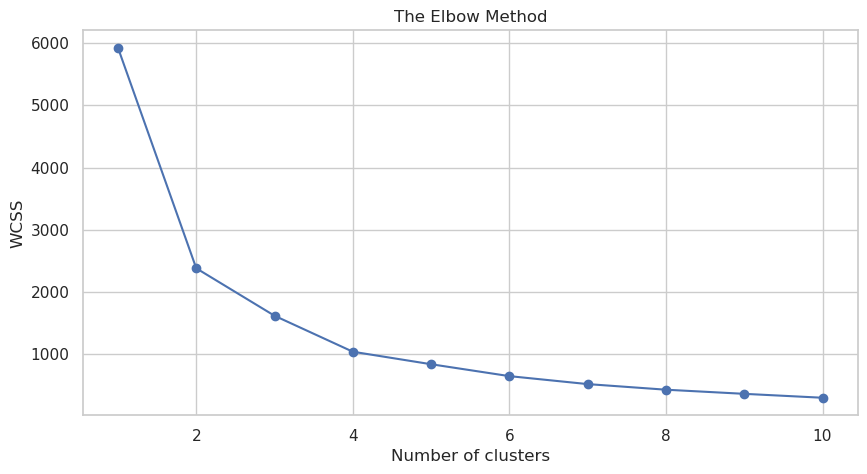

In [19]:
from sklearn.cluster import KMeans

# Removing the 'Day' column as it's not relevant for clustering
data_clustering = wide_standardized_noNA.drop('Day', axis=1)

# Using the Elbow Method to find the optimal number of clusters
wcss = []  # Within-Cluster Sum of Square
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=123)
    kmeans.fit(data_clustering)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe the 'elbow'
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Cluster days together using DBSCAN

In [20]:
from sklearn.cluster import DBSCAN

# DBSCAN clustering
# We need to specify the epsilon (eps) and minimum samples (min_samples) parameters
# As a starting point, we can use default values and adjust them based on the results
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(data_clustering)

# Adding the cluster labels to the original dataframe for analysis
data_with_dbscan = wide_standardized_noNA
data_with_dbscan['DBSCAN_Cluster'] = clusters_dbscan

# Checking the number of clusters and points in each cluster
cluster_counts = data_with_dbscan['DBSCAN_Cluster'].value_counts()

cluster_counts, data_with_dbscan.head()

( 1    358
  0     73
 -1     54
  2     30
  4     21
  3     12
 Name: DBSCAN_Cluster, dtype: int64,
 Variable         Day   PERD_GR  TR1_Corr_N  TR1_Pot_att  TR1_cosFi  \
 0         2022-01-06  0.507029   -1.600095    -1.292598   0.646569   
 1         2022-01-07  0.462060   -1.696996    -1.760198   0.603159   
 2         2022-01-08  0.446937   -1.600095    -1.978692   0.666575   
 3         2022-01-09  0.351997   -1.803588    -2.212015   0.394216   
 4         2022-01-10  0.179581   -1.498349    -1.863998   0.144100   
 
 Variable  TR2_Corr_N  TR2_Pot_att  TR2_cosFi  TR3_Corr_N  TR3_Pot_att  \
 0          -2.449617    -2.390089  -2.485613    2.370580     2.563919   
 1          -2.449617    -2.390089  -2.485613    2.387237     2.478809   
 2          -2.449617    -2.390089  -2.485613    2.341381     2.468522   
 3          -2.449617    -2.390089  -2.485613    2.334326     2.417645   
 4          -2.449617    -2.390089  -2.485613    2.489532     2.474847   
 
 Variable  TR3_cosFi  D

Pairs plot

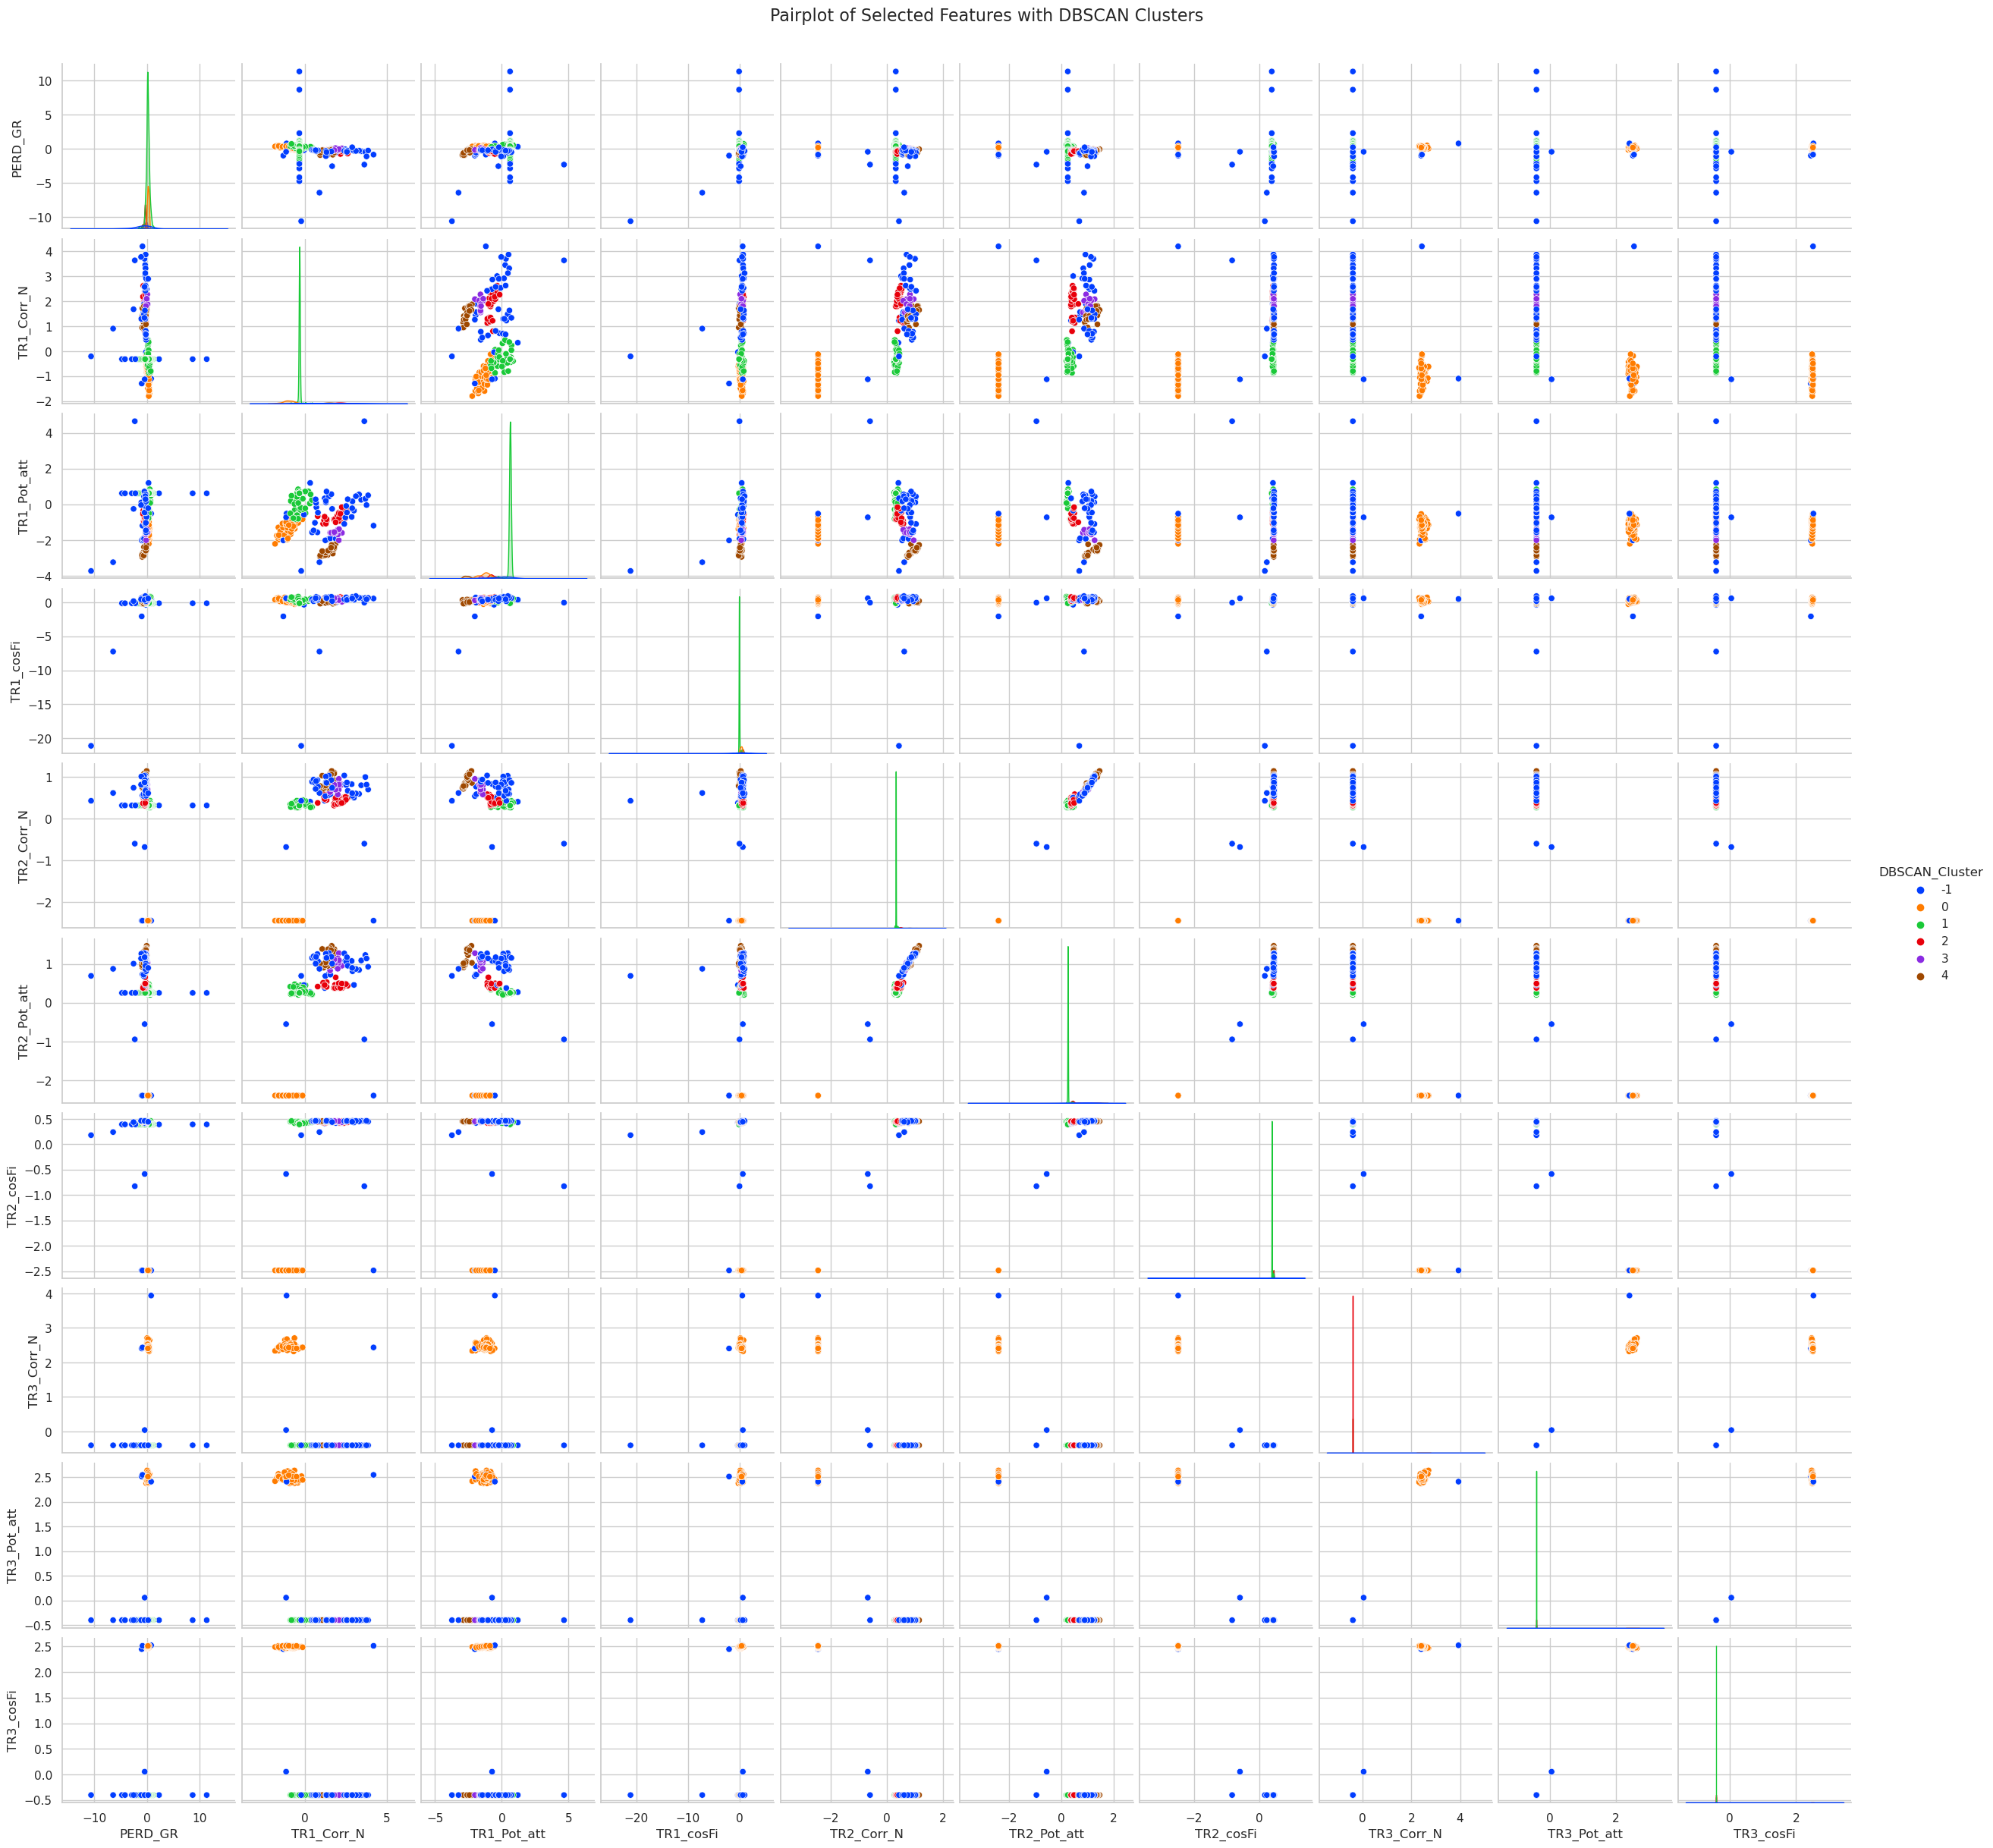

In [23]:
# Pairplot of the selected columns with DBSCAN cluster labels
sns.pairplot(data_with_dbscan, hue='DBSCAN_Cluster', palette='bright')

plt.suptitle("Pairplot of Selected Features with DBSCAN Clusters", size=16)
plt.subplots_adjust(top=0.95)  # Adjusting title position
plt.show()